In [1]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
import scipy.stats
import matplotlib.pyplot as plt

## 1. Prepare the data

In [2]:
theta = [0.03906292, 0.05119367, 0.06004468, 0.06790036, 0.19152079,
       0.28298816, 0.294665  , 0.3578136 , 0.48352862, 0.53058676,
       0.55175137, 0.57560289, 0.59751325, 0.6375209 , 0.65241862,
       0.65633352, 0.78698546, 0.8640421 , 0.87729053, 0.94568319]
aux1 = [ 0.53983961, -1.77528229,  1.31487654, -0.47344805, -1.0922299 ,
       -0.25002744, -0.9822943 ,  1.03126909,  0.49133378, -0.4466466 ,
       -0.80636008,  0.13126776, -1.21256024,  0.15999085, -0.75522304,
        0.34989599,  0.97754176, -0.13858525,  0.10385631,  0.30059104]
aux2 = [ 0.9682053 ,  0.86962384,  0.56778309,  0.46528234, -1.16537308,
       -2.03599479, -1.15541329,  3.34515739,  0.12672721, -0.6941789 ,
        0.55767443,  0.0991466 ,  0.63792617,  0.70311068, -0.91609315,
       -0.78601423,  1.1191818 , -0.98339611,  0.24452002, -0.58140974]
time_spent = [10.79768391, 10.87648065, 10.29274937, 10.78756647,  9.51844772,
        9.18078781,  9.90063639, 12.84823357, 10.92743478,  9.88927608,
       11.3373709 , 11.43996915, 11.88392171, -11.88135476, 11.73452467,
       11.18844425, 12.19144316, 11.35294826, 12.2385441 , 11.98428985]

In [3]:
#Create a dataframe from the lists provided
df = pd.DataFrame(list(zip(theta, aux1, aux2, time_spent)),columns =['theta','aux1','aux2','time_spent'])
df.head() #preview

,theta,aux1,aux2,time_spent
0,0.039063,0.539840,0.968205,10.797684
1,0.051194,-1.775282,0.869624,10.876481
2,0.060045,1.314877,0.567783,10.292749
3,0.067900,-0.473448,0.465282,10.787566
4,0.191521,-1.092230,-1.165373,9.518448


In [4]:
#Since this is all numeric data we can find summary statistics with describe function and identify anomolies
df.describe()

,theta,aux1,aux2,time_spent
count,20.000000,20.000000,20.000000,20.000000
mean,0.475222,-0.126610,0.069323,9.924470
std,0.292726,0.818612,1.168883,5.221924
min,0.039063,-1.775282,-2.035995,-11.881355
25%,0.260121,-0.768007,-0.818534,10.194721
50%,0.541169,-0.017364,0.185624,11.057940
75%,0.653397,0.385255,0.654222,11.771874
max,0.945683,1.314877,3.345157,12.848234


In [5]:
#Notice that there exists a negative value for time spent so we must remove all instances of negative values
np.where(df.time_spent<0)

(array([13]),)

In [6]:
#Remove 14th row, maintain the indexing 
df.drop(13, axis=0, inplace=True)
df.reset_index(drop=True, inplace=True)

In [7]:
#verify no more time_spent < 0 
np.where(df.time_spent<0)

(array([], dtype=int64),)

In [8]:
#View Dataframe we will actually use
df

,theta,aux1,aux2,time_spent
0,0.039063,0.539840,0.968205,10.797684
1,0.051194,-1.775282,0.869624,10.876481
2,0.060045,1.314877,0.567783,10.292749
3,0.067900,-0.473448,0.465282,10.787566
4,0.191521,-1.092230,-1.165373,9.518448
5,0.282988,-0.250027,-2.035995,9.180788
6,0.294665,-0.982294,-1.155413,9.900636
7,0.357814,1.031269,3.345157,12.848234
8,0.483529,0.491334,0.126727,10.927435
9,0.530587,-0.446647,-0.694179,9.889276


## 2. Build a model  

In [9]:
#This function outputs statistics based on alreay given formula
def regress_calc(input_cols):
    X = df[input_cols] #all columns from the dataframe other than time_spent
    y = df.iloc[:,-1] #isolate time_spent column
    n = len(X)
    lr = LinearRegression().fit(X, y) #run regression
    y_hat = lr.predict(X) #model predictions for X columns based on our data
    y_mean = np.mean(y) 
    intercept = lr.intercept_ #where does the y intercept occur? i.e. the time-spent column?
    B = lr.coef_ #coefficients for the model
    TSS = sum((y - y_mean)**2)
    RSS = sum((y - y_hat)**2)
    RegSS = TSS - RSS
    R2 = RegSS / TSS
    t_scores = B / (np.std(X)/np.sqrt(n)) 
    t_statistics = list(t_scores)
    p_values = (scipy.stats.t.sf(np.abs(t_scores), df=n))*2
    return intercept, B, R2, RSS, RegSS, TSS, input_cols, p_values, t_statistics

#This function creates a list of T/F for each p-value based on whether they are significant
def pvalue_sig(p_values):
    pvalue_sig = []
    alpha = 0.05
    for i in p_values:
        if i < alpha:
            pvalue_sig.append(True)
        else:
            pvalue_sig.append(False)
    return pvalue_sig

#This prints out our summary of each of the calculations requested
def regress_report(input_cols):
    intercept, B, R2, RSS, RegSS, TSS, input_cols, p_values, t_statistics = regress_calc(input_cols)
    pvalue_sign = pvalue_sig(p_values)
    print('\nR^2 = {}'.format(R2))
    print('Input columns: {}'.format(input_cols))
    print('Significance of P-Values = {}'.format(pvalue_sign))    
    print('Intercept = {}'.format(intercept))
    print('B = {}'.format(B))
    print('RSS = {}'.format(RSS))
    print('RegSS = {}'.format(RegSS))
    print('TSS = {}'.format(TSS))
    print('p_values = {}'.format(p_values))
    print('t_statistic = {}'.format(t_statistics))

In [10]:
reg_combos = [['theta','aux1','aux2'],['aux1','aux2'],['theta','aux1'],
              ['theta','aux2'],['theta'],['aux1'],['aux2']]

for i in reg_combos:
        regress_report(i)


R^2 = 0.8881796128595719
Input columns: ['theta', 'aux1', 'aux2']
Significance of P-Values = [True, False, True]
Intercept = 9.920094669515057
B = [ 2.3876759  -0.10000621  0.65613708]
RSS = 1.9659559596739313
RegSS = 15.615417258118747
TSS = 17.581373217792677
p_values = [6.45018856e-19 5.99313956e-01 2.33039270e-02]
t_statistic = [35.8609220625855, -0.5343249395736319, 2.4669850599262135]

R^2 = 0.41321369485899556
Input columns: ['aux1', 'aux2']
Significance of P-Values = [False, False]
Intercept = 11.070569154567039
B = [0.11530773 0.49808471]
RSS = 10.316509029773577
RegSS = 7.2648641880191
TSS = 17.581373217792677
p_values = [0.5451528  0.07657676]
t_statistic = [0.6160796737330165, 1.8727299331775378]

R^2 = 0.3813885891979512
Input columns: ['theta', 'aux1']
Significance of P-Values = [True, False]
Intercept = 10.283645737202516
B = [1.77398701 0.27796262]
RSS = 10.876038090096085
RegSS = 6.705335127696593
TSS = 17.581373217792677
p_values = [1.64016332e-16 1.53912205e-01]
t_s

`Notice that R^s for all 3 columns and {theta,aux2} are almost the same at ~.88. These are the highest in the combinations of imput columns. However, notice that {aux1} is insignificant throughout the experiment and in the all inclusive set, it is insignificant. Thus, our final model should be a regression to predict time_spent based on the columns: {theta,aux2} for optimal accuracy` 

## 3. Propose a setting for *theta*

In [11]:
X1 = df[['theta']] #isolate the theta column
y = df.iloc[:,-1] #isolate the time_spent column
reg1 = LinearRegression().fit(X1, y) #run a regression
y_hat = reg1.predict(X1) #model predictions for Theta based on our data

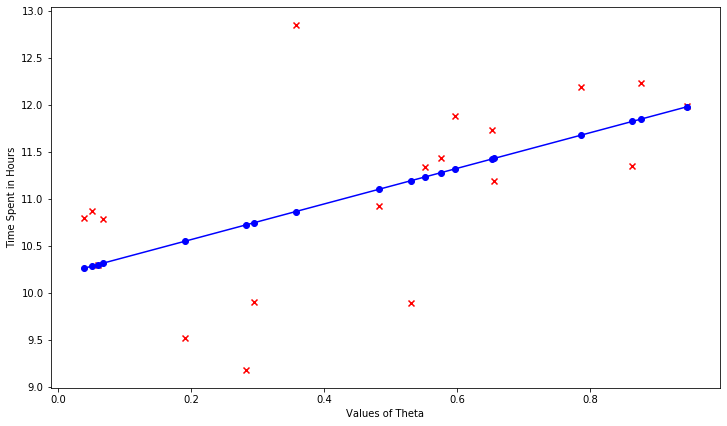

In [12]:
plt.figure(figsize=(12,7))
plt.xlabel('Values of Theta')
plt.ylabel('Time Spent in Hours')
plt.scatter(X1, y, c='r',marker='x') #plot the actual data in red x from our dataframe
plt.plot(X1, y_hat, c='b', marker='o') #plot our predicted data with blue dots and regression line

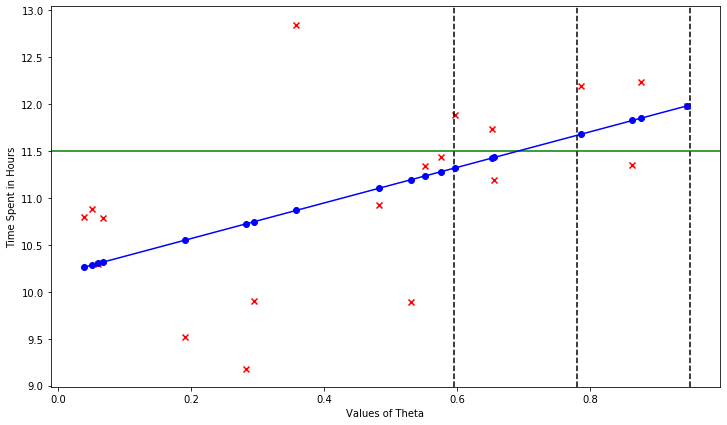

In [13]:
plt.figure(figsize=(12,7))
plt.xlabel('Values of Theta')
plt.ylabel('Time Spent in Hours')
plt.axvline(x=0.78, color='k', linestyle='dashed')
plt.axvline(x=0.95, color='k', linestyle='dashed')
plt.axvline(x=0.595, color='k', linestyle='dashed')
plt.axhline(y=11.5, color='g')
plt.scatter(X1, y, c='r',marker='x') 
plt.plot(X1, y_hat, c='b', marker='o')

`If we look closely at the graph, with the exception of the outlier around theta~3.8, most of the Values of theta before 0.6 are below the predicted graph. So, we shoudl really focus on the fact that theta should be over 0.6 so ensure higher values of the Time_spent variable. I would propose that since Theta is significant according to the p-values, we have theta between 0.8 and 0.9 so that we capture highest valies of time_spent. With teh exception of theta~3.8, 3/4 of the highest time_spent values are within theta= [0.78 and 0.95]. Furthermore, we can look at the dashed line above and observe that the time_spent values are also significantly more likely to be higher when theta is above 0.595. We have 5/7 values above 11.5 hrs in time_spent over theta=0.6. Thus, we are safe to say that with Theta>0.6 we will have higher time_spent and a bit more secure about that statement when Theta>0.78`

## 4. Experiment or observation?

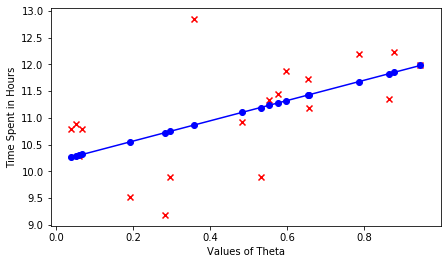

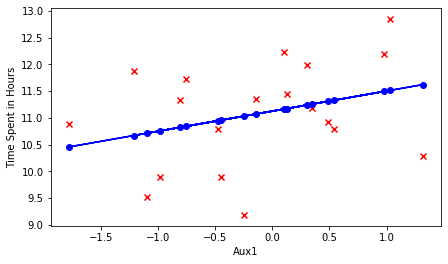

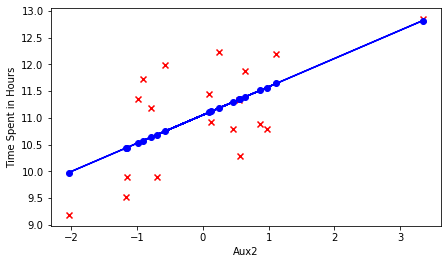

In [14]:
plt.figure(figsize=(7,4))
plt.xlabel('Values of Theta')
plt.ylabel('Time Spent in Hours')
plt.scatter(X1, y, c='r',marker='x') 
plt.plot(X1, y_hat, c='b', marker='o')

X2 = df[['aux1']] #isolate the aux1 column
reg2 = LinearRegression().fit(X2, y) #run a regression
y_hat2 = reg2.predict(X2)
plt.figure(figsize=(7,4))
plt.xlabel('Aux1')
plt.ylabel('Time Spent in Hours')
plt.scatter(X2, y, c='r',marker='x') 
plt.plot(X2, y_hat2, c='b', marker='o')

X3 = df[['aux2']] #isolate the aux2 column
reg3 = LinearRegression().fit(X3, y) #run a regression
y_hat3 = reg3.predict(X3)
plt.figure(figsize=(7,4))
plt.xlabel('Aux2')
plt.ylabel('Time Spent in Hours')
plt.scatter(X3, y, c='r',marker='x') 
plt.plot(X3, y_hat3, c='b', marker='o')

`First, now that we see a somewhat positive linear relationship between Theta and Time_spent, we will plot the regression  between the {aux1, aux2} columns and time_spent so we can analyze further. This is an observational data set. To qualify as an experimental dataset we must propose new data and use experimental methods to determine if results were replicable. We did not do that instead we simply had observations that we analyzed.

We see that Theta always is significant based on p-values and that there is a positive linear relationship. Looking at the graphs (directly) above, we see that Theta and Aux2 has a higher positive relationship than aux1 and that is reflected by the R^2 for the combinations with {theta, aux2}.`  